# 💧 Project Brief: Borehole Water Quality Prediction

## 🎯 Goal
Use Machine Learning to predict contamination risks in water sources — helping identify unsafe boreholes early and guide interventions.

## 📘 Notebook Series Plan
| Step | File Name | Purpose |
|------|------------|----------|
| 1.0 (Current) | `1.0-Water-Quality-Data-Acquisition.ipynb` | Acquire and store open water-quality datasets. |
| 2.0 | `2.0-Exploratory-Data-Analysis.ipynb` | Explore, clean, and visualize data. |
| 3.0 | `3.0-Model-Training-and-Evaluation.ipynb` | Build and evaluate ML models predicting “Safe” or “Unsafe” water. |

In [9]:
# --- Step 1: Import Core Libraries ---
import pandas as pd
import os

# --- Step 2: Define Absolute File Path ---
# We use the absolute path relative to the user's home directory (~)
# This is much more reliable than relative paths (../../)
# Note: '~' is expanded by the shell, but in Python we use os.path.expanduser
ABSOLUTE_FILE_PATH = os.path.expanduser('~/jetty-ai-lab/data/raw/water_quality_data.csv')

# --- Step 3: Fetch Data from Local Disk ---
print(f"Starting data load from local disk: {ABSOLUTE_FILE_PATH}")

try:
    # Read the file directly from the disk path
    df = pd.read_csv(ABSOLUTE_FILE_PATH)

    print(f"✅ Successfully loaded {len(df)} records from local disk.")

except FileNotFoundError:
    print(f"❌ Error: File not found at {ABSOLUTE_FILE_PATH}. Please ensure the file is named 'water_quality_data.csv' and is in the '~/jetty-ai-lab/data/raw/' directory.")
    df = None # Set df to None on failure to avoid NameError
except Exception as e:
    print(f"❌ An unexpected error occurred during loading: {e}")
    df = None

# --- Step 4: Initial Inspection ---
print("\n--- Initial Data Inspection ---")
if df is not None:
    print(df.head())
    print("\nData Shape:", df.shape)
else:
    print("Cannot display data: Load failed.")

Starting data load from local disk: /Users/apple/jetty-ai-lab/data/raw/water_quality_data.csv
✅ Successfully loaded 3276 records from local disk.

--- Initial Data Inspection ---
         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.0

In [10]:
## 2.0 Initial Inspection and Cleaning Prep

print("--- DataFrame Info (Data Types & Non-Null Counts) ---")
df.info()

print("\n--- Summary Statistics ---")
print(df.describe())

print("\n--- Check for Missing Values (Null Count per Column) ---")
print(df.isnull().sum())

--- DataFrame Info (Data Types & Non-Null Counts) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB

--- Summary Statistics ---
                ph     Hardness        Solids  Chloramines      Sulfate  \
count  2785.000000  3276.000000   3276.000000  3276.000000  2495.000000   
mean      7.080795   196.369496  22014.092526     7.12227

In [11]:
## 3.0 Data Cleaning: Handling Missing Values

# Calculate the median for the columns with missing values
ph_median = df['ph'].median()
sulfate_median = df['Sulfate'].median()
trihalomethanes_median = df['Trihalomethanes'].median()

# Impute (fill) the missing values using the median
df['ph'].fillna(ph_median, inplace=True)
df['Sulfate'].fillna(sulfate_median, inplace=True)
df['Trihalomethanes'].fillna(trihalomethanes_median, inplace=True)

# Verify that all missing values have been handled
print("--- Missing Values after Imputation ---")
print(df.isnull().sum())

--- Missing Values after Imputation ---
ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


/var/folders/1t/7xz3dqb161g7mldhsl2q0qw00000gn/T/ipykernel_31925/2868942816.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ph'].fillna(ph_median, inplace=True)
/var/folders/1t/7xz3dqb161g7mldhsl2q0qw00000gn/T/ipykernel_31925/2868942816.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beha

In [12]:
## 4.0 Data Preprocessing

# 1. Separate Features (X) and Target (y)
# Drop the target column 'Potability' from the features
X = df.drop('Potability', axis=1)
y = df['Potability']

# 2. Split the data into training and testing sets
# We will use 80% for training and 20% for testing (random_state ensures reproducibility)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Print the resulting shapes to confirm the split
print("--- Data Split Shapes ---")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

--- Data Split Shapes ---
X_train shape: (2620, 9)
X_test shape: (656, 9)
y_train shape: (2620,)
y_test shape: (656,)


In [13]:
## 5.0 Model Training: Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# 1. Initialize the Model
# We set random_state for reproducible results
model = RandomForestClassifier(random_state=42)

# 2. Train the Model (Fit the model to the training data)
print("Starting Model Training...")
model.fit(X_train, y_train)
print("Model Training Complete. Generating Predictions...")

# 3. Generate Predictions on the Test Set
y_pred = model.predict(X_test)

Starting Model Training...
Model Training Complete. Generating Predictions...


In [14]:
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions
y_pred = model.predict(X_test)

# Print evaluation metrics
print("--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

--- Confusion Matrix ---
[[350  62]
 [152  92]]

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.70      0.85      0.77       412
           1       0.60      0.38      0.46       244

    accuracy                           0.67       656
   macro avg       0.65      0.61      0.61       656
weighted avg       0.66      0.67      0.65       656



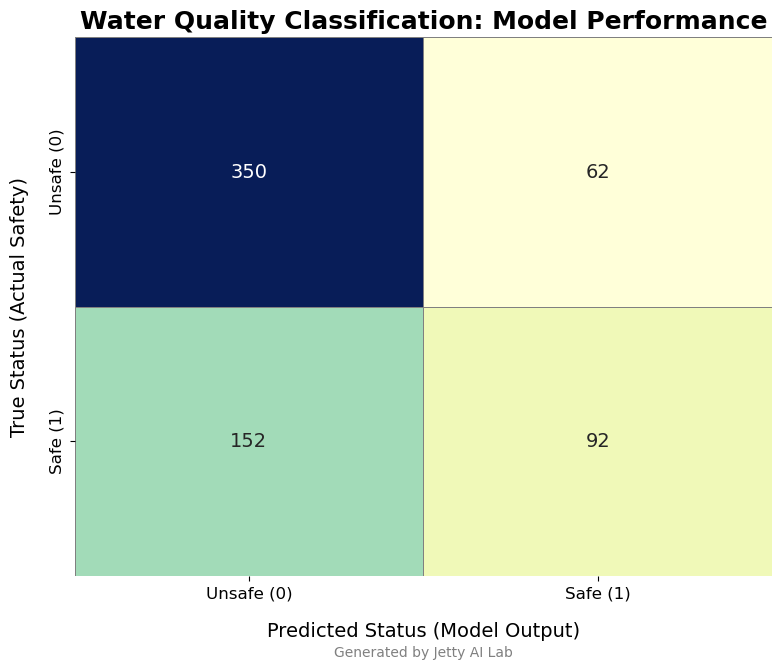

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

# --- Assume y_test and y_pred are defined from your previous cells ---

# 1. Calculate the raw Confusion Matrix
cm = confusion_matrix(y_test, y_pred) 

# 2. Define the labels (Crucial for clear interpretation)
class_names = ['Unsafe (0)', 'Safe (1)'] # Simplified for clarity, assuming 0=unsafe, 1=safe

# 3. Create a DataFrame for a clean Seaborn plot
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

# 4. Plot the heatmap
plt.figure(figsize=(9, 7)) # Slightly larger for better visibility
sns.heatmap(df_cm, 
            annot=True, # Display numbers in the cells
            fmt='d', # Format numbers as integers
            cmap='YlGnBu', # A different, vibrant colormap
            cbar=False, 
            linewidths=0.7, # Slightly thicker lines
            linecolor='grey',
            annot_kws={"size": 14}) # Adjust annotation font size

# 5. Add enhanced titles and labels
plt.title('Water Quality Classification: Model Performance', fontsize=18, fontweight='bold')
plt.ylabel('True Status (Actual Safety)', fontsize=14, labelpad=15)
plt.xlabel('Predicted Status (Model Output)', fontsize=14, labelpad=15)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.text(0.5, -0.15, 'Generated by Jetty AI Lab', horizontalalignment='center', 
         fontsize=10, color='gray', transform=plt.gca().transAxes) # Professional footer

# Save the high-resolution image
plt.savefig('water_quality_cm_counts.png', dpi=300, bbox_inches='tight')
plt.show()


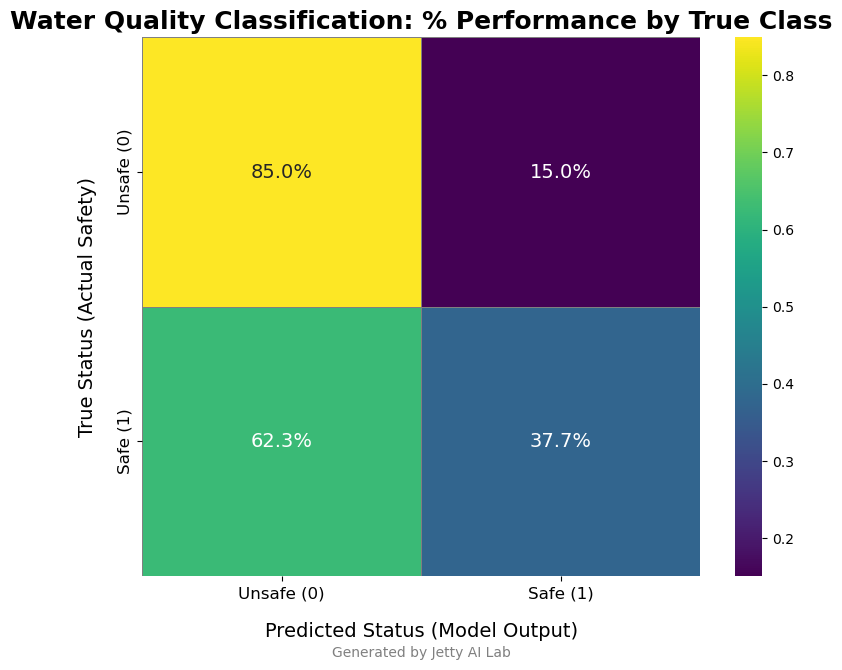

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

# --- Assume y_test and y_pred are defined from your previous cells ---

# 1. Calculate the raw Confusion Matrix
cm = confusion_matrix(y_test, y_pred) 

# 2. Normalize the Confusion Matrix to percentages
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Normalize rows (True Labels)

# 3. Define the labels
class_names = ['Unsafe (0)', 'Safe (1)'] 

# 4. Create a DataFrame for a clean Seaborn plot
df_cm_norm = pd.DataFrame(cm_norm, index=class_names, columns=class_names)

# 5. Plot the heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(df_cm_norm, 
            annot=True, # Display numbers in the cells
            fmt='.1%', # Format as percentage with 1 decimal place
            cmap='viridis', # A different, modern colormap
            cbar=True, # Show color bar for percentages
            linewidths=0.7, 
            linecolor='grey',
            annot_kws={"size": 14})

# 6. Add enhanced titles and labels
plt.title('Water Quality Classification: % Performance by True Class', fontsize=18, fontweight='bold')
plt.ylabel('True Status (Actual Safety)', fontsize=14, labelpad=15)
plt.xlabel('Predicted Status (Model Output)', fontsize=14, labelpad=15)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.text(0.5, -0.15, 'Generated by Jetty AI Lab', horizontalalignment='center', 
         fontsize=10, color='gray', transform=plt.gca().transAxes)

# Save the high-resolution image
plt.savefig('water_quality_cm_percentages.png', dpi=300, bbox_inches='tight')
plt.show()